<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales - 2023</h1>
    <p>Docente: Rodrigo Del Rosso<p>
    <p>Asistentes: Sebastián Calcagno y Braian Drago <p>
    <p>Integrantes: Cerutti, Garcia Rio, Levit, Marchetta <p>
</div>

# Lectura y preparacion de los datos  <br>


In [1]:
# Modulos a instalar
!pip install pmdarima
!pip install arch
!pip install pystan
!pip install darts

!pip install prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.3/814.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 14.0

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import scipy.stats
import pylab
import statsmodels.api as sm
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality, plot_acf
from darts.metrics import mape

import prophet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive

In [8]:
file_path = '/content/per-capita-energy-use.csv'
df = pd.read_csv(file_path)
df.head()
df

,Entity,Code,Year,energy_consumption_per_capita
0,Afghanistan,AFG,1980,623.92865
1,Afghanistan,AFG,1981,786.83690
2,Afghanistan,AFG,1982,926.65125
3,Afghanistan,AFG,1983,1149.19590
4,Afghanistan,AFG,1984,1121.57290
...,...,...,...,...
10597,Zimbabwe,ZWE,2017,3068.01150
10598,Zimbabwe,ZWE,2018,3441.98580
10599,Zimbabwe,ZWE,2019,3003.65530
10600,Zimbabwe,ZWE,2020,2680.13180


In [9]:
df = df[df['Entity'] == 'Argentina']
df.head()

,Entity,Code,Year,energy_consumption_per_capita
326,Argentina,ARG,1965,14896.737
327,Argentina,ARG,1966,15139.622
328,Argentina,ARG,1967,15337.348
329,Argentina,ARG,1968,15612.201
330,Argentina,ARG,1969,15887.447


In [10]:
cols = ['Year', 'energy_consumption_per_capita']
df = df.loc[:, cols]
df.head()

,Year,energy_consumption_per_capita
326,1965,14896.737
327,1966,15139.622
328,1967,15337.348
329,1968,15612.201
330,1969,15887.447


In [11]:
# gdp['Anio'] = pd.to_datetime(gdp['Anio'], format='%Y')
# gdp.set_index("Anio", inplace=True)

df.rename(columns={'energy_consumption_per_capita': 'Energy'}, inplace=True)

In [12]:
#gdp.dtypes

In [13]:
df['Energy'] = df['Energy'].astype(float)

# Modelos

###### Division del dataset

In [14]:
df.head()

,Year,Energy
326,1965,14896.737
327,1966,15139.622
328,1967,15337.348
329,1968,15612.201
330,1969,15887.447


In [15]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

###### Darts

In [16]:
df.head()

,Year,Energy
326,1965,14896.737
327,1966,15139.622
328,1967,15337.348
329,1968,15612.201
330,1969,15887.447


In [17]:
# Importar librerías necesarias de Darts
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality
from darts.metrics import mape
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse
import matplotlib.pyplot as plt

# Crear la serie temporal de Darts
series = TimeSeries.from_dataframe(df, 'Year', 'Energy')

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Configurar y entrenar el modelo NBEATS
model = NBEATSModel(input_chunk_length=10, output_chunk_length=5, n_epochs=100)
model.fit(train, verbose=True)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(len(test))

# Calcular métricas de interés (MAE en este caso)
mape_score_dart = mape(test, predictions)
mse_score_dart= mse(test, predictions)
mae_score_dart = mae(test, predictions)
rmse_score_dart= rmse(test, predictions)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.3 K     Non-trainable params
6.1 M     Total params
24.342    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
mape_score_dart

6.859350981612433

In [19]:
mse_score_dart

3103182.734100226

In [20]:
mae_score_dart

1481.569866838724

In [21]:
rmse_score_dart

1761.5852900442335

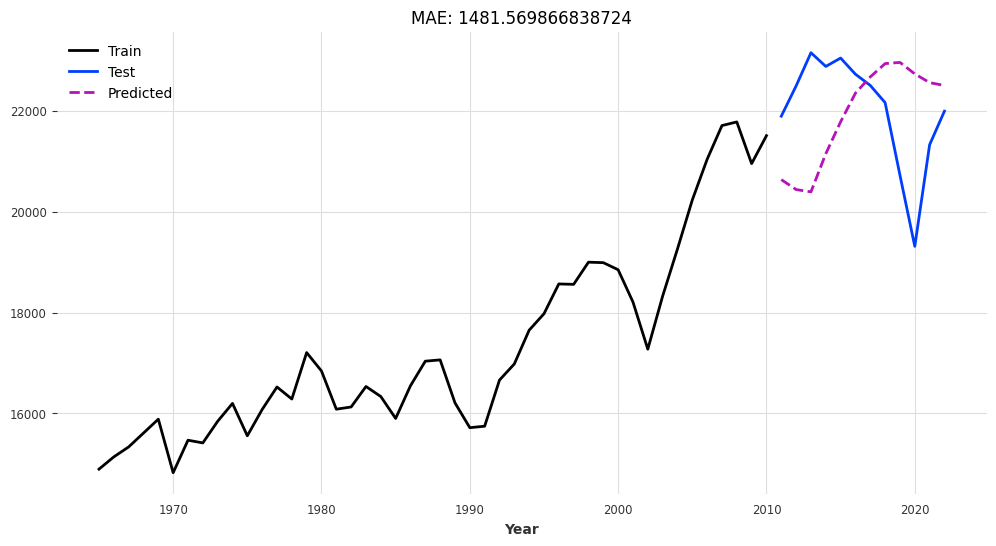

In [22]:
#Graficar las series de tiempo
plt.figure(figsize=(12, 6))
train.plot(label='Train', lw=2)
test.plot(label='Test', lw=2)
predictions.plot(label='Predicted', lw=2, linestyle='--')
plt.title(f'MAE: {mae_score_dart}')
plt.legend()
plt.show()



In [23]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00


###### Prophet

In [25]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Convertir la serie temporal de Darts a un DataFrame de pandas
prophet_df = pd.DataFrame({'ds': train.pd_dataframe().index, 'y': train.pd_dataframe().values.flatten()})

# Configurar y entrenar el modelo Prophet
model_prophet = Prophet()
model_prophet.fit(prophet_df)

# Crear un DataFrame con las fechas futuras para las predicciones
future = model_prophet.make_future_dataframe(periods=len(test), freq='Y')

# Realizar las predicciones
forecast = model_prophet.predict(future)

from sklearn.metrics import mean_absolute_percentage_error

# Calculando metricas de interes
mape_score_prophet = mean_absolute_percentage_error(test.pd_dataframe().values, forecast[-len(test):]['yhat'].values)
mae_score_prophet = mean_absolute_error(test.pd_dataframe().values, forecast[-len(test):]['yhat'].values)
#mse_score_prophet = mse(test.pd_dataframe().values, forecast[-len(test):]['yhat'].values)
#rmse_score_prophet =rmse(test.pd_dataframe().values, forecast[-len(test):]['yhat'].values)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpolyc7w2r/hhex4_uq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpolyc7w2r/lc8isosp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85078', 'data', 'file=/tmp/tmpolyc7w2r/hhex4_uq.json', 'init=/tmp/tmpolyc7w2r/lc8isosp.json', 'output', 'file=/tmp/tmpolyc7w2r/prophet_modelixl63gx9/prophet_model-20231205002116.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


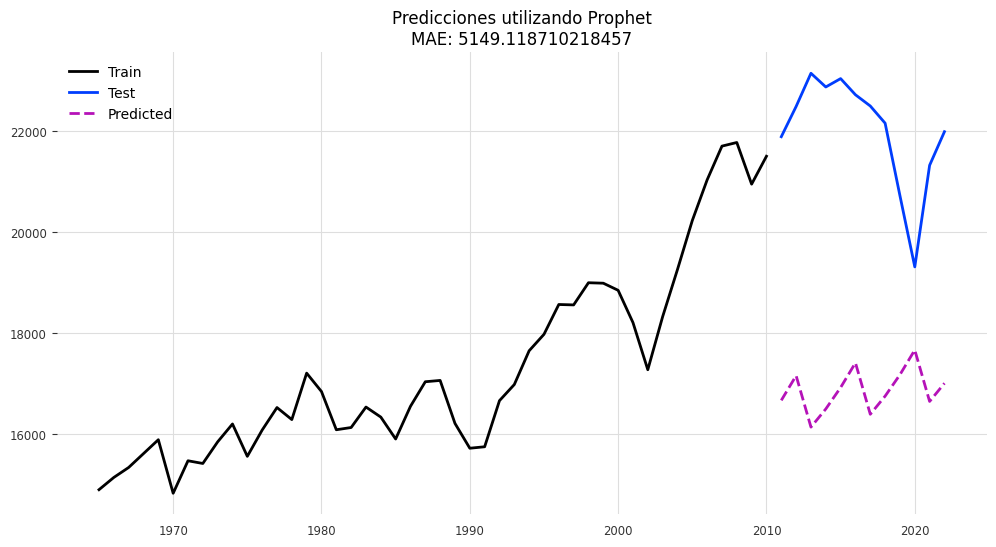

In [27]:
# Visualizar las series de tiempo de entrenamiento, prueba y predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.pd_dataframe().index, train.pd_dataframe().values, label='Train', lw=2)
plt.plot(test.pd_dataframe().index, test.pd_dataframe().values, label='Test', lw=2)
plt.plot(test.pd_dataframe().index, forecast[-len(test):]['yhat'].values, label='Predicted', lw=2, linestyle='--')
plt.title(f'Predicciones utilizando Prophet\nMAE: {mae_score_prophet}')
plt.legend()
plt.show()

###### Redes Neuronales

In [28]:
!pip install tensorflow


1/1 [==============================] - 4s 4s/step

1/1 [==============================] - 1s 907ms/step

1/1 [==============================] - 1s 844ms/step

1/1 [==============================] - 1s 830ms/step

 40%|████      | 4/10 [01:13<01:31, 15.26s/trial, best loss: 0.03271439786198645]

1/1 [==============================] - 1s 835ms/step

 50%|█████     | 5/10 [01:21<01:03, 12.73s/trial, best loss: 0.03271439786198645]

1/1 [==============================] - 1s 866ms/step

1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 1s 888ms/step

1/1 [==============================] - 1s 874ms/step

1/1 [==============================] - 1s 893ms/step

100%|██████████| 10/10 [02:03<00:00, 12.37s/trial, best loss: 0.03271439786198645]
Epoch 1/150
2/2 [==============================] - 6s 14ms/step - loss: 0.2024
Epoch 2/150
2/2 [==============================] - 0s 13ms/step - loss: 0.1763
Epoch 3/150
2/2 [==============================] - 0s 14ms/step - loss: 0.1546
Epoch 4/150
2/2 [==============================] - 0s 17ms/step - loss: 0.1341
Epoch 5/150
2/2 [==============================] - 0s 14ms/step - loss: 0.1097
Epoch 6/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0913
Epoch 7/150
2/2 [==============================] - 0s 14ms/step - loss: 0.0768
Epoch 8/150
2/2 [==============================] - 0s 21ms/step - loss: 0.0586
Epoch 9/150
2/2 [=

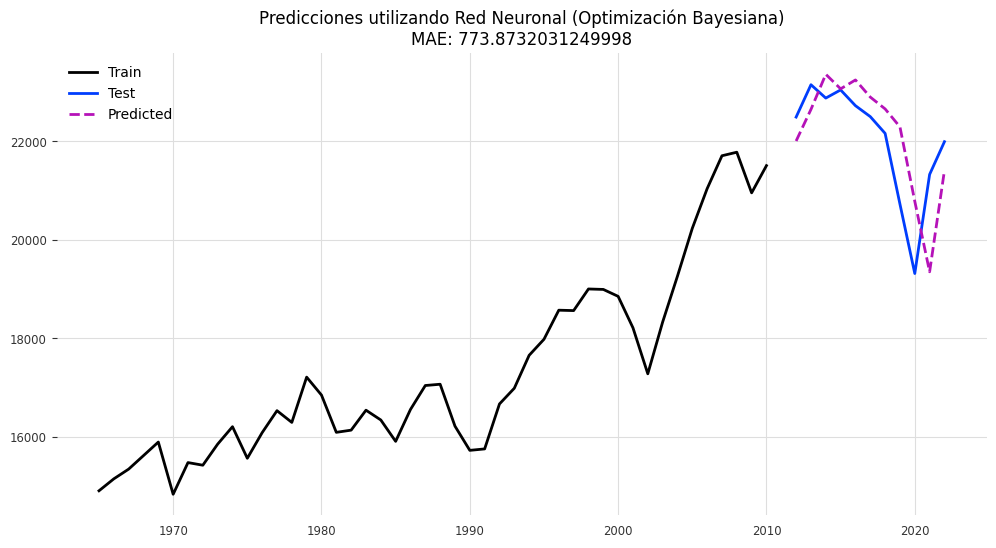

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from hyperopt import fmin, tpe, hp

# Escalar los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.pd_dataframe().values.reshape(-1, 1))
test_scaled = scaler.transform(test.pd_dataframe().values.reshape(-1, 1))

# Preparar los datos para LSTM
def prepare_lstm_data(data, lags):
    X, y = [], []
    for i in range(len(data)-lags):
        X.append(data[i:(i+lags), 0])
        y.append(data[i+lags, 0])
    return np.array(X), np.array(y)

lags = 1

X_train, y_train = prepare_lstm_data(train_scaled, lags)
X_test, y_test = prepare_lstm_data(test_scaled, lags)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'units_lstm1': hp.choice('units_lstm1', [50, 100]),
    'units_lstm2': hp.choice('units_lstm2', [50, 100]),
    'dense_units': hp.choice('dense_units', [50, 100]),
    'dropout_lstm1': hp.uniform('dropout_lstm1', 0, 0.5),
    'dropout_lstm2': hp.uniform('dropout_lstm2', 0, 0.5),
    'dropout_dense': hp.uniform('dropout_dense', 0, 0.5),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32, 64])
}

# Función objetivo para la optimización
def objective(params):
    model_nn = Sequential([
        LSTM(units=params['units_lstm1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(params['dropout_lstm1']),
        LSTM(units=params['units_lstm2']),
        Dropout(params['dropout_lstm2']),
        Dense(units=params['dense_units']),
        Dropout(params['dropout_dense']),
        Dense(units=1)
    ])

    model_nn.compile(optimizer='adam', loss='mean_squared_error')

    model_nn.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    predictions_scaled = model_nn.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    mape_score = mean_absolute_error(test.pd_dataframe().values[lags:], predictions) / test.pd_dataframe().values[lags:].mean()

    return mape_score

# Realizar la optimización bayesiana
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

# Obtener los mejores hiperparámetros
best_units_lstm1 = [50, 100][best['units_lstm1']]
best_units_lstm2 = [50, 100][best['units_lstm2']]
best_dense_units = [50, 100][best['dense_units']]
best_dropout_lstm1 = best['dropout_lstm1']
best_dropout_lstm2 = best['dropout_lstm2']
best_dropout_dense = best['dropout_dense']
best_epochs = [50, 100, 150][best['epochs']]
best_batch_size = [32, 64][best['batch_size']]

# Entrenar el modelo con los mejores hiperparámetros
best_model_nn = Sequential([
    LSTM(units=best_units_lstm1, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_dropout_lstm1),
    LSTM(units=best_units_lstm2),
    Dropout(best_dropout_lstm2),
    Dense(units=best_dense_units),
    Dropout(best_dropout_dense),
    Dense(units=1)
])

best_model_nn.compile(optimizer='adam', loss='mean_squared_error')
best_model_nn.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Realizar predicciones en el conjunto de prueba
best_predictions_scaled = best_model_nn.predict(X_test)
best_predictions = scaler.inverse_transform(best_predictions_scaled)

#Calcular el MAE
best_mae_score_rd = mean_absolute_error(test.pd_dataframe().values[lags:], best_predictions)




# Visualizar las series de tiempo
plt.figure(figsize=(12, 6))
plt.plot(train.pd_dataframe().index, train.pd_dataframe().values, label='Train', lw=2)
plt.plot(test.pd_dataframe().index[lags:], test.pd_dataframe().values[lags:], label='Test', lw=2)
plt.plot(test.pd_dataframe().index[lags:], best_predictions, label='Predicted', lw=2, linestyle='--')
plt.title(f'Predicciones utilizando Red Neuronal (Optimización Bayesiana)\nMAE: {best_mae_score_rd}')
plt.legend()
plt.show()


###### SVM

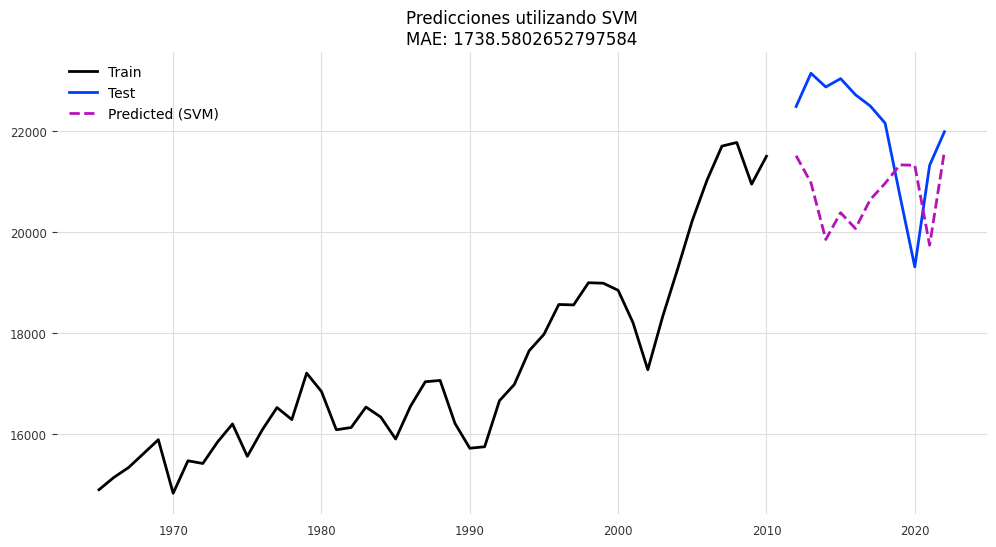

In [31]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler_svm = StandardScaler()
train_scaled_svm = scaler_svm.fit_transform(train.pd_dataframe().values.reshape(-1, 1))
test_scaled_svm = scaler_svm.transform(test.pd_dataframe().values.reshape(-1, 1))

# Preparar los datos para SVM
def prepare_svm_data(data, lags):
    X, y = [], []
    for i in range(len(data)-lags):
        X.append(data[i:(i+lags), 0])
        y.append(data[i+lags, 0])
    return np.array(X), np.array(y)

lags_svm = 1

X_train_svm, y_train_svm = prepare_svm_data(train_scaled_svm, lags_svm)
X_test_svm, y_test_svm = prepare_svm_data(test_scaled_svm, lags_svm)

# Crear y entrenar el modelo SVM
svm_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svm_model.fit(X_train_svm, y_train_svm)

# Hacer predicciones en el conjunto de prueba
predictions_svm_scaled = svm_model.predict(X_test_svm)
predictions_svm = scaler_svm.inverse_transform(predictions_svm_scaled.reshape(-1, 1))

# Calcular el MAE
mae_score_svm = mean_absolute_error(test.pd_dataframe().values[lags_svm:], predictions_svm)

# Visualizar las series de tiempo
plt.figure(figsize=(12, 6))
plt.plot(train.pd_dataframe().index, train.pd_dataframe().values, label='Train', lw=2)
plt.plot(test.pd_dataframe().index[lags_svm:], test.pd_dataframe().values[lags_svm:], label='Test', lw=2)
plt.plot(test.pd_dataframe().index[lags_svm:], predictions_svm, label='Predicted (SVM)', lw=2, linestyle='--')
plt.title(f'Predicciones utilizando SVM\nMAE: {mae_score_svm}')
plt.legend()
plt.show()


# Predicciones futuras

Dado que el modelo de menor MAPE (Mean Absolute Percentage Error) es el generado mediante la red neuronal, procedemos a utilizarlo para pronosticar datos futuros no presentens en el conjunto de datos:

1/1 [==============================] - 0s 38ms/step


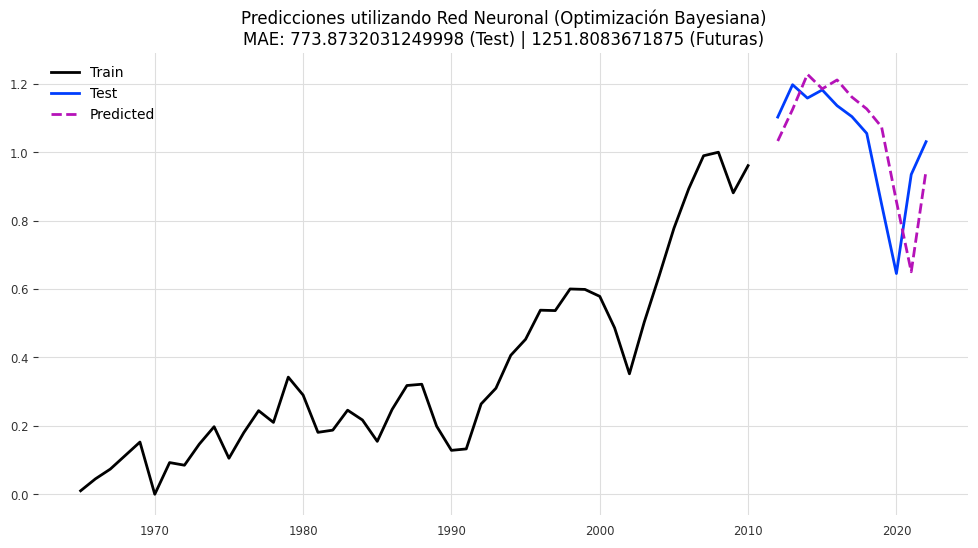

In [33]:
# Obtener las fechas para las predicciones futuras (ahora con frecuencia anual)
last_index_value = test.pd_dataframe().index[-1]
future_dates = pd.date_range(start=f"{last_index_value + 1}-01-01", periods=10, freq='A')
future_index = pd.DatetimeIndex(future_dates)

# Preparar datos para predicción
X_pred, y_pred = prepare_lstm_data(test_scaled, lags)
X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))

# Realizar predicciones para las próximas 10 observaciones
future_predictions_scaled = []
last_observation_scaled = X_pred[-1]

for _ in range(10):
    # Reshape la última observación para que tenga la forma adecuada
    last_observation_reshaped = np.reshape(last_observation_scaled, (1, lags, 1))

    # Realizar predicción
    next_prediction_scaled = best_model_nn.predict(last_observation_reshaped)

    # Agregar la predicción a la lista de predicciones futuras
    future_predictions_scaled.append(next_prediction_scaled[0, 0])

    # Actualizar la última observación con la nueva predicción
    last_observation_scaled = np.roll(last_observation_scaled, -1)
    last_observation_scaled[-1] = next_prediction_scaled

# Invertir las predicciones futuras utilizando el escalador
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Calcular el MAPE para las predicciones futuras
future_mae_score = mean_absolute_error(test.pd_dataframe().values[lags: lags + 10], future_predictions[:10])

# Normalizar todas las series para que estén en la misma escala
train_scaled_normalized = scaler.transform(train.pd_dataframe().values.reshape(-1, 1))
test_scaled_normalized = scaler.transform(test.pd_dataframe().values.reshape(-1, 1))
best_predictions_normalized = scaler.transform(best_predictions)
future_predictions_normalized = scaler.transform(future_predictions)

# Visualizar las series de tiempo extendidas con las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(train.pd_dataframe().index, train_scaled_normalized, label='Train', lw=2)
plt.plot(test.pd_dataframe().index[lags:], test_scaled_normalized[lags:], label='Test', lw=2)
plt.plot(test.pd_dataframe().index[lags:], best_predictions_normalized, label='Predicted', lw=2, linestyle='--')

plt.title(f'Predicciones utilizando Red Neuronal (Optimización Bayesiana)\nMAE: {best_mae_score_rd} (Test) | {future_mae_score} (Futuras)')
plt.legend()
plt.show()


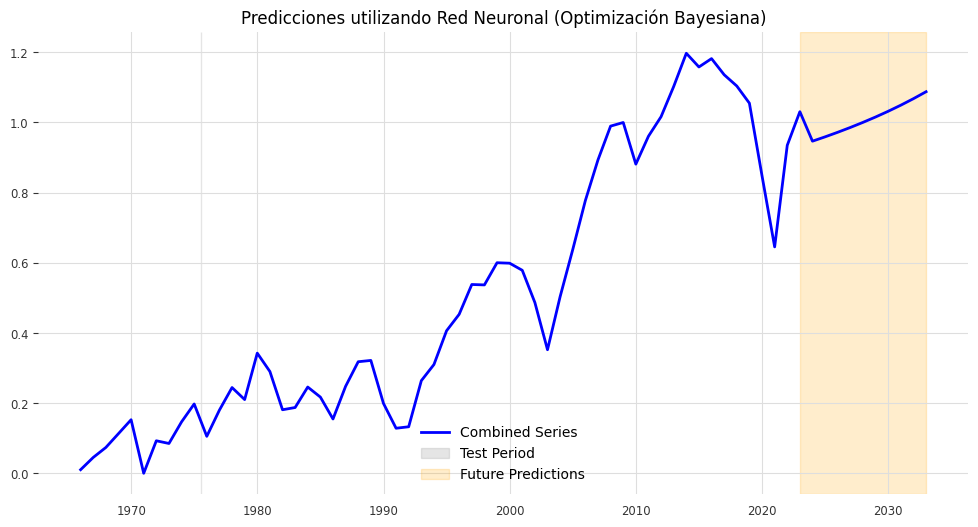

In [34]:
initial_index_value = train.pd_dataframe().index[0]
initial_date = pd.date_range(start=f"{initial_index_value}-01-01", periods=1, freq='A')
initial_index = pd.DatetimeIndex(initial_date)

# Normalizar todas las series para que estén en la misma escala
train_scaled_normalized = scaler.transform(train.pd_dataframe().values.reshape(-1, 1))
test_scaled_normalized = scaler.transform(test.pd_dataframe().values.reshape(-1, 1))
future_predictions_normalized = scaler.transform(future_predictions)

# Combinar las series de tiempo de entrenamiento y prueba en una única serie continua
combined_series_normalized = np.concatenate([train_scaled_normalized, test_scaled_normalized, future_predictions_normalized])

# Crear un índice continuo para la serie combinada
combined_index = pd.date_range(start=initial_index[0], periods=len(combined_series_normalized), freq='A')

# Obtener las fechas de inicio y fin del período de prueba y las predicciones futuras
test_start = test.pd_dataframe().index[0]
test_end = test.pd_dataframe().index[-1]
future_start = combined_index[-11]
future_end = combined_index[-1]

# Visualizar la serie continua con colores diferentes para entrenamiento, prueba y predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(combined_index, combined_series_normalized, label='Combined Series', lw=2, color='blue')

# Resaltar el período de prueba con un color diferente
plt.axvspan(test_start, test_end, color='gray', alpha=0.2, label='Test Period')

# Resaltar las predicciones futuras con otro color
plt.axvspan(future_start, future_end, color='orange', alpha=0.2, label='Future Predictions')

plt.title(f'Predicciones utilizando Red Neuronal (Optimización Bayesiana)')
plt.legend()
plt.show()


# Auto ML

In [35]:
pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.2-py2.py3-none-any.whl size=265363806 sha256=25c6ace79e80188aeb06940e37abf1ec73b32e27dbcd728528b4d26ff4cfe281
  Stored in directory: /root/.cache/pip/wheels/e9/ea/ab/889709967692e30c57c46137edd2cae6b2768bb65ec7cb8aa5
Successfully built h2o


###### H2O

In [36]:
# Importar bibliotecas necesarias

import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

# Inicializar H2O
h2o.init()

# Convertir tu serie temporal a un DataFrame de pandas
df = df.reset_index()

# Inicializar un objeto H2OFrame
h2o_df = h2o.H2OFrame(df)

# Definir las columnas predictoras y la variable objetivo
x = list(df.columns[:-1])  # Convertir el Index a una lista
y = df.columns[-1]   # La última columna (variable objetivo)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_size_h2o = int(len(h2o_df) * 0.8)
train_h2o, test_h2o = h2o_df[:train_size_h2o, :], h2o_df[train_size_h2o:, :]

# Configurar y entrenar AutoML
aml = H2OAutoML(max_runtime_secs=600)  # Establecer el tiempo máximo de ejecución en segundos
aml.train(x=x, y=y, training_frame=train_h2o)

# Ver los resultados del AutoML
lb = aml.leaderboard
print(lb)

# Seleccionar el mejor modelo del AutoML
best_model = aml.leader

# Hacer predicciones en el conjunto de prueba
predictions_h2o = best_model.predict(test_h2o)

# Convertir las predicciones a un DataFrame de pandas
predictions_df = h2o.as_list(predictions_h2o)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpddq59e0p
  JVM stdout: /tmp/tmpddq59e0p/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpddq59e0p/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unknownUser_b15430
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███
00:29:27.476: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 46.0.

████████████████████████████████████████████████████████████| (done) 100%
model_id                                         rmse     mse      mae      rmsle    mean_residual_deviance
GBM_grid_1_AutoML_1_20231205_02910_model_524  393.505  154846  325.674  0.0231828                    154846
GBM_grid_1_AutoML_1_20231205_02910_model_47   394.826  155887  330.671  0.0233241                    155887
GBM_grid_1_AutoML_1_20231205_02910_model_207  395.275  156242  324.479  0.023186                     156242
GBM_grid_1_AutoML_1_20231205_02910_model_149  398.761  159010  334.671  0.023357                     159010
GBM_grid_1_AutoML_1_20231205_02910_model_383  399.154  159324  335.668  0.0232315                    159324
GBM_grid

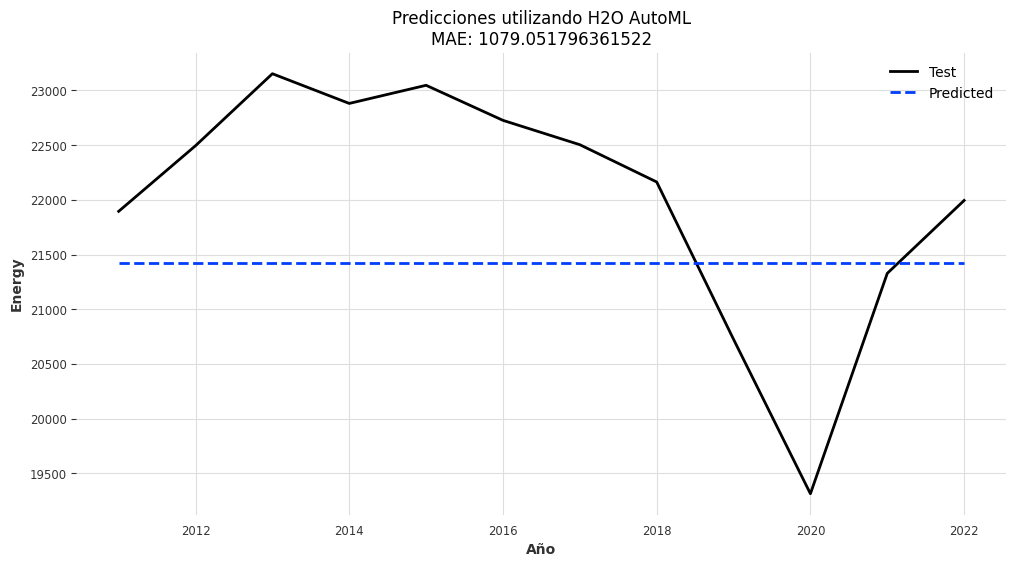

In [37]:
mae_h2o = mean_absolute_error(test_h2o[y].as_data_frame().values, predictions_df.values)

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(df['Year'][train_size_h2o:], df['Energy'][train_size_h2o:], label='Test', lw=2)
plt.plot(df['Year'][train_size_h2o:], predictions_df.values, label='Predicted', lw=2, linestyle='--')
plt.title(f'Predicciones utilizando H2O AutoML\nMAE: {mae_h2o}')
plt.xlabel('Año')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [38]:
# Obtener información sobre el modelo seleccionado
print(f"Modelo Seleccionado: {best_model.algo}")

# Otras propiedades del modelo
print(f"Parámetros del Modelo: {best_model.params}")
print(f"Tipo de Modelo: {best_model.model_id}")


Modelo Seleccionado: gbm
Parámetros del Modelo: {'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_grid_1_AutoML_1_20231205_02910_model_524', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_grid_1_AutoML_1_20231205_02910_model_524'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20231205_02910_training_py_1_sid_8b79', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20231205_02910_training_py_1_sid_8b79'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20231205_02910_training_py_1_sid_8b79', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20231205_02910_training_py_1_sid_8b79'}}, 'validation_frame': {'default': None, 'actual': None, 'input': None}, 'nfolds': {'default': 0, 'actual': 5, 'input': 5}, 'k

Podemos observar que el modelo seleccionado por Auto ML con esta libreria, fue un gbm que predice una constante.

In [39]:
# Apagar H2O
h2o.shutdown()

H2O session _sid_8b79 closed.


<ipython-input-39-b68b04c51667>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


###### PYCARET

In [40]:
!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [41]:
import pandas as pd
from pycaret.time_series import *

# Leer datos y convertir a formato de series temporal de sktime
file_path = '/content/per-capita-energy-use.csv'
df = pd.read_csv(file_path)
df = df[df['Entity'] == 'Argentina']
df.rename(columns={'energy_consumption_per_capita': 'Energy'}, inplace=True)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index("Year", inplace=True)
df['Energy'] = pd.to_numeric(df['Energy'], errors='coerce')  # Convertir a tipo numérico
df_series = pd.Series(df['Energy'].values, index=df.index)

# Configurar el entorno de Pycaret con validación cruzada de series temporales
exp = setup(data=df_series, session_id=123, fold_strategy='sliding', fold=5)

# Comparar modelos de series temporales
best_model = compare_models()

# Resumen del modelo seleccionado
print(f"Modelo Seleccionado: {best_model}")

# Obtener detalles del modelo seleccionado
model_details = pull()

# Hacer predicciones en el conjunto de prueba
predictions = predict_model(best_model)

,Description,Value
0,session_id,123
1,Target,Time Series
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(58, 1)"
5,Transformed data shape,"(58, 1)"
6,Transformed train set shape,"(57, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.5232,1.2894,742.1786,742.1786,0.0357,0.0349,0.1740
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.8006,1.5202,891.1199,891.1199,0.0438,0.0425,0.2840
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.8537,1.5663,913.6353,913.6353,0.0451,0.0434,0.2620
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8582,1.5696,916.2593,916.2593,0.0454,0.0435,0.1940
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.8868,1.5945,928.7667,928.7667,0.0459,0.0440,0.2260
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8988,1.6047,931.8421,931.8421,0.0458,0.0441,0.4340
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.9473,1.6457,957.9605,957.9605,0.0467,0.0453,0.1200
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.9782,1.6712,974.2013,974.2013,0.0481,0.0462,0.1100
arima,ARIMA,2.0802,1.7520,1044.2081,1044.2081,0.0504,0.0505,0.2380
croston,Croston,2.1599,1.8256,1055.2431,1055.2431,0.0503,0.0501,0.0880


Processing:   0%|          | 0/109 [00:00<?, ?it/s]

Modelo Seleccionado: BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                   n_jobs=1)],
                    regressor=XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=123, ...),
                    window_length=1)


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,XGBRegressor,3.5257,2.8375,1873.0151,1873.0151,0.0852,0.0889


In [42]:
# compare models using OOP
best = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.5232,1.2894,742.1786,742.1786,0.0357,0.0349,0.1360
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.8006,1.5202,891.1199,891.1199,0.0438,0.0425,0.1580
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.8537,1.5663,913.6353,913.6353,0.0451,0.0434,0.4380
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8582,1.5696,916.2593,916.2593,0.0454,0.0435,0.1500
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.8868,1.5945,928.7667,928.7667,0.0459,0.0440,0.3420
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8988,1.6047,931.8421,931.8421,0.0458,0.0441,0.1760
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.9473,1.6457,957.9605,957.9605,0.0467,0.0453,0.1180
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.9782,1.6712,974.2013,974.2013,0.0481,0.0462,0.1060
arima,ARIMA,2.0802,1.7520,1044.2081,1044.2081,0.0504,0.0505,0.2580
croston,Croston,2.1599,1.8256,1055.2431,1055.2431,0.0503,0.0501,0.0520


Processing:   0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
# plot forecast
plot_model(best, plot = 'forecast')

In [43]:
# plot forecast for 36 months in future
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 15})

El modelo seleccionado por la libreria pycaret, es un Extra Tree, que posee un MAPE del 3%.

In [44]:
# residuals plot
plot_model(best, plot = 'residuals')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
